# Mods

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.stats import boxcox

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     RandomizedSearchCV, 
                                     GridSearchCV)

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             RocCurveDisplay,
                             precision_recall_curve, 
                             average_precision_score,
                             roc_auc_score, 
                             roc_curve, auc)

from sklearn.neighbors import NearestCentroid
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

import time
import warnings
warnings.filterwarnings("ignore")

In [13]:
Df = pd.read_csv("/home/r00323024/loan default/loan.csv")
description = pd.read_excel('/home/r00323024/loan default/LCDataDictionary.xlsx').dropna()

In [ ]:
description.style.set_properties(subset=['Description'], **{'width': '1000px'})
# description.to_csv('/home/r00323024/loan default/t.txt', sep='\t', index=False) 

# EDA

In [52]:
df = Df.copy()

In [64]:
status_map = {
    'Current': 0,
    'Fully Paid': 0,
    'In Grace Period': 1,
    'Late (16-30 days)': 1,
    'Late (31-120 days)': 1,
    'Does not meet the credit policy. Status:Fully Paid': 1,
    'Charged Off': 2,
    'Does not meet the credit policy. Status:Charged Off': 2,
    'Default': 2
}

df['loan_status'] = df['loan_status'].map(status_map)


In [ ]:
df['loan_amnt'].hist()
df

In [22]:
df['loan_amnt'], lambda_ = boxcox(df['loan_amnt'] ) 
scaler = MinMaxScaler()
cols = []
df['loan_amnt'] = scaler.fit_transform(df[['loan_amnt']])

In [53]:
# filter 
cols = ['sub_grade','issue_d','purpose','zip_code','addr_state','earliest_cr_line','title','last_pymnt_d','last_credit_pull_d']
df = df.drop(cols,axis=1)


In [58]:
Grade = ['D','E','F','G']
df = df[df['grade'].isin(Grade)]


In [6]:
#Create a function to calculate the percentage of missing values for each column
def missing_values(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

#check missing values
miss_values = missing_values(df)

Dataframe has 16 columns.
There are 13 columns that have missing values.


In [54]:
#Function to keep only columns with less than 30 missing values
def filter_columns_with_less_than_3_percent_missing(df):
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    cols_to_keep = mis_val_percent[mis_val_percent < 3].index.tolist()
    filtered_df = df[cols_to_keep]
    return filtered_df

df = filter_columns_with_less_than_3_percent_missing(df)
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,mort_acc,num_bc_sats,num_sats,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,RENT,55000.0,Not Verified,...,0.0,3.0,9.0,1.0,0.0,16901.0,36500.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,MORTGAGE,90000.0,Source Verified,...,3.0,4.0,13.0,1.0,0.0,99468.0,15000.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,MORTGAGE,59280.0,Source Verified,...,2.0,3.0,8.0,0.0,0.0,11749.0,13800.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,MORTGAGE,92000.0,Source Verified,...,3.0,1.0,10.0,0.0,0.0,36151.0,5000.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,MORTGAGE,57250.0,Not Verified,...,2.0,3.0,12.0,0.0,0.0,29674.0,9300.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260663,12000,12000,12000.0,60 months,14.08,279.72,C,MORTGAGE,58000.0,Not Verified,...,2.0,3.0,12.0,0.0,0.0,45212.0,6200.0,N,Cash,N
2260664,12000,12000,12000.0,60 months,25.82,358.01,E,MORTGAGE,30000.0,Not Verified,...,4.0,2.0,10.0,0.0,0.0,12928.0,11400.0,N,Cash,N
2260665,10000,10000,10000.0,36 months,11.99,332.10,B,OWN,64000.0,Source Verified,...,3.0,1.0,6.0,0.0,0.0,36448.0,2000.0,N,Cash,N
2260666,12000,12000,12000.0,60 months,21.45,327.69,D,RENT,60000.0,Not Verified,...,0.0,2.0,8.0,0.0,0.0,65238.0,22000.0,N,Cash,N


In [55]:

categorical_columns = df.select_dtypes(include=['object', 'category']).columns

file_path = "/home/r00323024/loan default/unique_values.txt"

with open(file_path, "w") as f:
    for col in categorical_columns:
        unique_values = df[col].unique()
        f.write(f"Unique values in '{col}':\n")
        for value in unique_values:
            f.write(f"{value}\n")
        f.write("\n")


In [45]:
file_path = '/home/r00323024/loan default/names.txt'

with open(file_path, 'w') as file:
     for column in df.columns:
        file.write(column + '\n')

In [56]:
df = df.dropna()
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,mort_acc,num_bc_sats,num_sats,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,RENT,55000.0,Not Verified,...,0.0,3.0,9.0,1.0,0.0,16901.0,36500.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,MORTGAGE,90000.0,Source Verified,...,3.0,4.0,13.0,1.0,0.0,99468.0,15000.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,MORTGAGE,59280.0,Source Verified,...,2.0,3.0,8.0,0.0,0.0,11749.0,13800.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,MORTGAGE,92000.0,Source Verified,...,3.0,1.0,10.0,0.0,0.0,36151.0,5000.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,MORTGAGE,57250.0,Not Verified,...,2.0,3.0,12.0,0.0,0.0,29674.0,9300.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260663,12000,12000,12000.0,60 months,14.08,279.72,C,MORTGAGE,58000.0,Not Verified,...,2.0,3.0,12.0,0.0,0.0,45212.0,6200.0,N,Cash,N
2260664,12000,12000,12000.0,60 months,25.82,358.01,E,MORTGAGE,30000.0,Not Verified,...,4.0,2.0,10.0,0.0,0.0,12928.0,11400.0,N,Cash,N
2260665,10000,10000,10000.0,36 months,11.99,332.10,B,OWN,64000.0,Source Verified,...,3.0,1.0,6.0,0.0,0.0,36448.0,2000.0,N,Cash,N
2260666,12000,12000,12000.0,60 months,21.45,327.69,D,RENT,60000.0,Not Verified,...,0.0,2.0,8.0,0.0,0.0,65238.0,22000.0,N,Cash,N


In [32]:
#list numeric features
num_col = df.select_dtypes(exclude=['object']).columns

#Check missing values in numeric features
num_mv = df[num_col].isnull().sum().to_string()

print("Missing values in numeric features:\n", num_mv)

Missing values in numeric features:
 loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
int_rate                      0
installment                   0
annual_inc                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
total_rec_prncp               0
total_rec_int                 0
total_rec_late_fee            0
recoveries                    0
collection_recovery_fee       0
last_pymnt_amnt               0
collections_12_mths_ex_med    0
policy_code                   0
acc_now_delinq                0
acc_open_past_24mths          0
chargeoff_within_12_mths      0
delinq_amnt                   0
mor

In [65]:
X = df.drop(['loan_status'], axis=1)
X = pd.get_dummies(X, drop_first=True, sparse=True).astype(int)
X
y=df['loan_status']

In [66]:
X

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,pymnt_plan_y,initial_list_status_w,application_type_Joint App,hardship_flag_Y,disbursement_method_DirectPay,debt_settlement_flag_Y
1,30000,30000,30000,18,777,90000,26,0,0,13,...,0,0,1,0,0,1,0,0,0,0
2,5000,5000,5000,17,180,59280,10,0,0,8,...,0,0,1,0,0,1,0,0,0,0
3,4000,4000,4000,18,146,92000,16,0,0,10,...,0,0,1,0,0,1,0,0,0,0
8,5000,5000,5000,17,180,53580,21,0,1,8,...,0,0,1,0,0,1,0,0,0,0
10,5500,5500,5500,22,211,50000,15,1,0,6,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260661,21000,21000,21000,30,691,90000,26,1,2,8,...,0,0,0,1,0,0,0,0,0,0
2260662,30000,30000,30000,30,984,100000,22,0,2,9,...,0,0,0,1,0,0,0,0,0,0
2260664,12000,12000,12000,25,358,30000,19,3,1,10,...,0,0,0,0,0,1,1,0,0,0
2260666,12000,12000,12000,21,327,60000,30,2,1,8,...,0,1,0,0,0,1,0,0,0,0


# RF

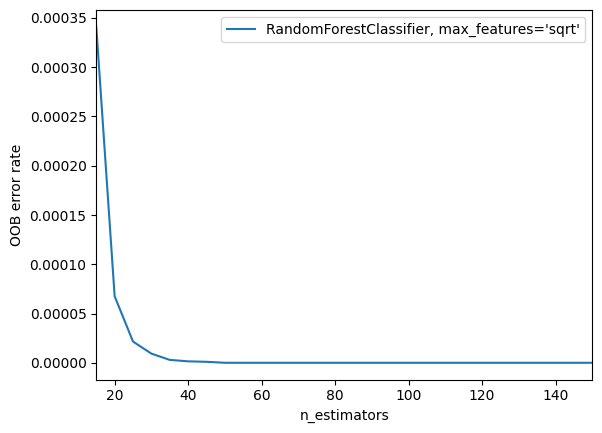

In [106]:
from collections import OrderedDict
#  Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.


ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=42,
        ),
    )]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 50

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

OOB Error: 0.0246


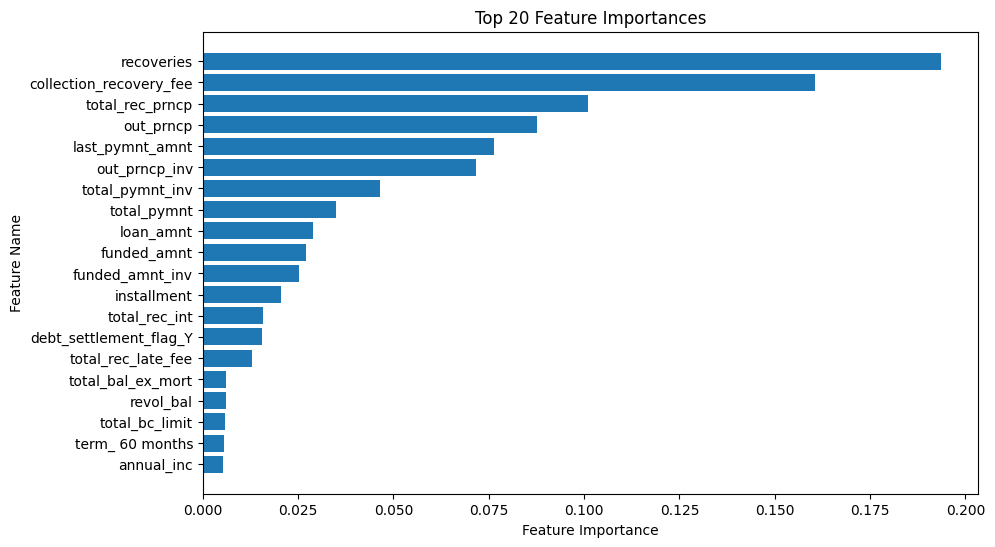

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 1

rf_clf = RandomForestClassifier(
    warm_start=True,
    oob_score=True,
    max_features="sqrt",
    random_state=RANDOM_STATE,
    n_estimators=54, 
    bootstrap=True      
)

rf_clf.fit(X, y)

oob_error = 1 - rf_clf.oob_score_
print(f"OOB Error: {oob_error:.4f}")


importances = rf_clf.feature_importances_
feature_names = X.columns

# 将特征重要性与特征名称关联起来，并按重要性降序排序
feature_importances = list(zip(feature_names, importances))
feature_importances.sort(key=lambda x: x[1], reverse=True)

# 提取排名前10的特征及其重要性
top_features = feature_importances[:20]
top_feature_names = [x[0] for x in top_features]
top_feature_importances = [x[1] for x in top_features]

plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  
plt.show()


In [69]:
from sklearn.metrics import confusion_matrix
oob_predictions = rf_clf.oob_decision_function_
predicted_classes = oob_predictions.argmax(axis=1)
cm = confusion_matrix(y, predicted_classes)

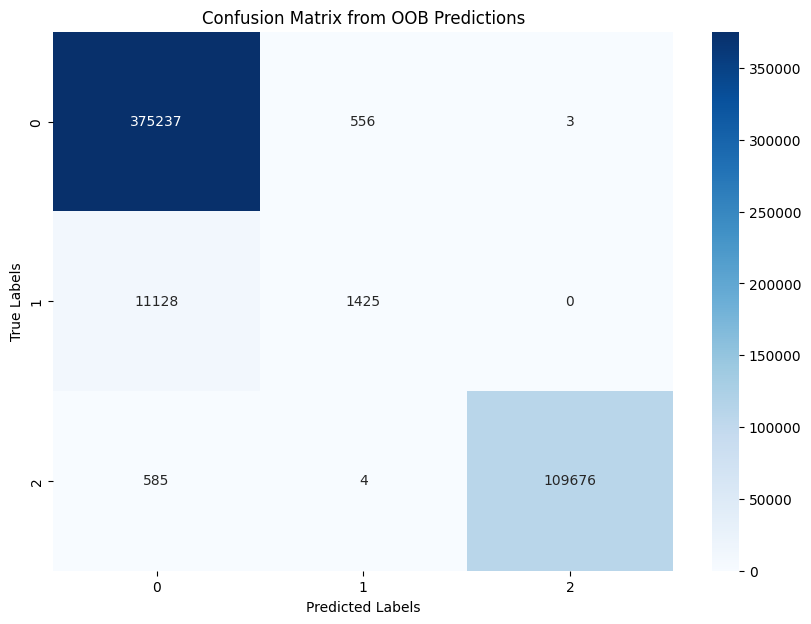

In [70]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix from OOB Predictions')
plt.show()